## Imports

In [1]:
import numpy as np
import torch

## Configuration

In [2]:
from omegaconf import OmegaConf

CONFIG = OmegaConf.create({
    # Model
    "model": "WideResNet-28-10-torchdistill",
    "num_classes": 10,
    # Dataset
    "image_size": 32,
    "pure_noise_mean": [0.4988, 0.5040, 0.4926],
    "pure_noise_std": [0.2498, 0.2480, 0.2718],
    "per_class_count": 50,
    "valid_transform_reprs": [
        "ConvertImageDtype(float)",
        "Normalize((0.4988, 0.5040, 0.4926), (0.2498, 0.2480, 0.2718))",
    ],
    "batch_size": 128,
    "num_workers": 8,
    "enable_pin_memory": True,
    "checkpoint_url": "https://drive.google.com/uc?id=1ZEaevP97mXYdLU_Jv6S5sm2oR3TZZLeF",
})

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Download checkpoint

In [4]:
import gdown

url = CONFIG.checkpoint_url
checkpoint_filepath = "checkpoints/for_analysis.pt"
gdown.download(url, checkpoint_filepath, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ZEaevP97mXYdLU_Jv6S5sm2oR3TZZLeF
To: /workspace/pure-noise/checkpoints/for_analysis.pt
100%|██████████| 292M/292M [00:03<00:00, 90.6MB/s] 


'checkpoints/for_analysis.pt'

## Set Random Seed

In [5]:
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

## Initialize Model

In [6]:
from initializers import initialize_model

net = initialize_model(
    model_name=CONFIG.model, 
    num_classes=CONFIG.num_classes, 
    enable_dar_bn=False,
    dropout_rate=0,
)

In [7]:
from checkpointing import load_checkpoint

load_checkpoint(net, optimizer=None, checkpoint_filepath=checkpoint_filepath)

In [8]:
import torch.nn as nn

embedding_net = nn.Sequential(*list(net.children())[:-1])
embedding_net = embedding_net.to(device)
embedding_net = embedding_net.eval()

## Generate Pure Noise Images

In [9]:
from replace_with_pure_noise import sample_noise_images

noise_images = sample_noise_images(
    image_size=CONFIG.image_size,
    mean=CONFIG.pure_noise_mean,
    std=CONFIG.pure_noise_std, 
    count=CONFIG.per_class_count,
)
noise_images = noise_images.to(device)

## Load Dataset

In [10]:
from torch.utils.data import DataLoader

from datasets.cifar10 import build_train_dataset, build_valid_dataset
from initializers import initialize_transforms

valid_transform = initialize_transforms(CONFIG.valid_transform_reprs)
valid_dataset = build_valid_dataset(transform=valid_transform)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=CONFIG.batch_size,
    num_workers=CONFIG.num_workers,
    pin_memory=CONFIG.enable_pin_memory,
)

## Generate Embeddings

In [11]:
with torch.no_grad():
    noise_image_outputs = embedding_net(noise_images)
    noise_image_outputs = noise_image_outputs.cpu().numpy()

noise_image_labels = np.array([CONFIG.num_classes] * CONFIG.per_class_count)

In [12]:
# Get all the data
with torch.no_grad():
    valid_inputs = []
    valid_labels = []
    for minibatch_i, (inputs, labels) in enumerate(valid_loader):
        inputs = inputs.float().to(device)
        labels = labels.to(device)

        valid_inputs.extend(inputs.cpu().tolist())
        valid_labels.extend(labels.cpu().tolist())

    valid_inputs = np.array(valid_inputs)
    valid_labels = np.array(valid_labels)

In [13]:
valid_inputs.shape, valid_labels.shape

((10000, 3, 32, 32), (10000,))

In [14]:
# Get few data examples for each class
with torch.no_grad():
    valid_subset_outputs = []
    valid_subset_labels = []
    for class_ in np.arange(CONFIG.num_classes):
        per_class_inputs = valid_inputs[valid_labels == class_][:CONFIG.per_class_count]
        per_class_labels = valid_labels[valid_labels == class_][:CONFIG.per_class_count]

        per_class_inputs = torch.FloatTensor(per_class_inputs).to(device)
        per_class_labels = torch.FloatTensor(per_class_labels).to(device)

        per_class_outputs = embedding_net(per_class_inputs)
        valid_subset_outputs.extend(per_class_outputs.cpu().tolist())
        valid_subset_labels.extend(per_class_labels.cpu().tolist())

    valid_subset_outputs = np.array(valid_subset_outputs)
    valid_subset_labels = np.array(valid_subset_labels)

## Run TSNE

In [15]:
outputs = np.concatenate([valid_subset_outputs, noise_image_outputs], axis=0)[:, :, 0, 0]
labels = np.concatenate([valid_subset_labels, noise_image_labels], axis=0)

In [16]:
from sklearn.manifold import TSNE

outputs_tsne = TSNE(random_state=0).fit_transform(outputs)

## Plot TSNE

In [17]:
import matplotlib

cmap = matplotlib.cm.get_cmap("Set3")
colors = [cmap(i) for i in np.linspace(0, 1, 11)]

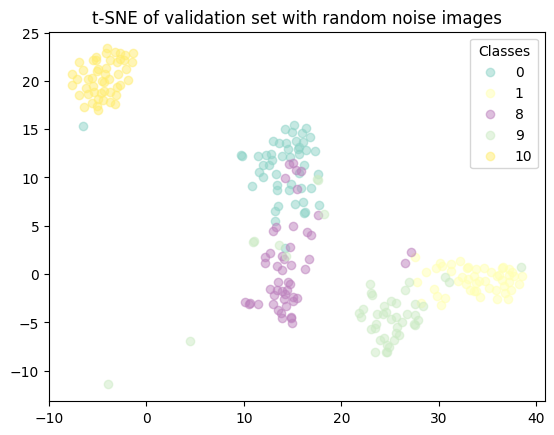

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for label in [0, 1, 8, 9, 10]:
    filtered_outputs_tsne = outputs_tsne[labels == label]
    filtered_labels = labels[labels == label]
    sc = ax.scatter(
        x=filtered_outputs_tsne[:, 0],
        y=filtered_outputs_tsne[:, 1],
        color=colors[label],
        label=label,
        alpha=0.5,
    )
ax.legend(loc="upper right", title="Classes")
ax.set_title("t-SNE of validation set with random noise images")
fig.show()

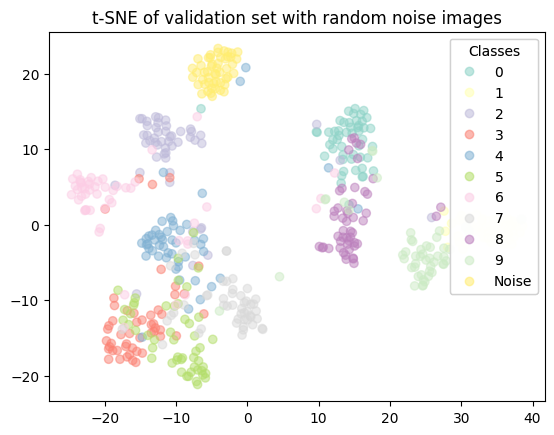

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sc = ax.scatter(
    x=outputs_tsne[:, 0],
    y=outputs_tsne[:, 1],
    c=labels,
    alpha=0.5,
    cmap="Set3",
)
# produce a legend with the unique colors from the scatter
legend_elements = sc.legend_elements()
legend_elements[1][-1] = "Noise"
legend = ax.legend(*legend_elements, loc="upper right", title="Classes")
ax.add_artist(legend)
ax.set_title("t-SNE of validation set with random noise images")
fig.show()